# Movie Recommendation System

### Introduction

The purpose of a Recommendation System is to reach out to the target audience with products or items that are relevant to them rather than just flooding them with random things. This makes the lives of customers easier by mitigating the hassle of manually searching for product of their likes and also lead to increase of revenues in the companies providing the service.
Not surprisingly, Amazon and Netflix are the two biggest companies who leverage recommendation systems. 
With the growing popularity in such systems, many other companies are attempting to develop the most accurate systems. The systems  vary depending on the industry based on the nature of products and their descriptive data, even though the underlying algorithm might be the same.

This project will cover different techniques to build movie recommendation systems while attempting to highlight core differences and find the one with best performance. 

In [25]:
import matplotlib
matplotlib.use("svg")
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use("ggplot")
from mpl_toolkits.axes_grid1 import ImageGrid
from scipy import spatial
from pandas import DataFrame as df
from datetime import datetime
import pandas as pd
import numpy as np
import collaborative_filtering as cf
import linear_regression as lr
import networkx as nx
import seaborn
import movie_parsing
import process_data
from pyfm import pylibfm
from sklearn.metrics import mean_squared_error
import math
from sklearn.feature_extraction import DictVectorizer
import tokenizer
import experiemnt_fm

links = pd.read_csv('./data/ml-latest-small/links.csv')
movies = pd.read_csv("./data/ml-latest-small/movies.csv")
ratings = pd.read_csv("./data/ml-latest-small/ratings.csv")
df_movies = pd.read_csv('./data/movie_objects.csv', encoding = 'latin1')

df_user = (pd.read_csv("./data/u.user",sep='|',names=['userId', 'age', 'gender', 'occupation', 'zip_code']))[:671]

### Datasets Compilation

##### MovieLens 
This project will make use of the typical recommendation systems dataset known as the MovieLens dataset as compiled by Grouplens. Due to computational limitations, the smallest dataset (last updated 10/2016) will be explored rather than the complete 20M ratings one. 

The smallest dataset contains 100,000 ratings and 1,300 tag applications applied to 9,000 movies by 700 users. The dataset consists of four .csv files: links.csv, linking movies to IMDb and TMDb; movies.csv, containing movie title and genres; tags.csv, containing a tag or keyword for the movie; and ratings.csv, which has the movie ratings by the users. In addition, the users data included in the complete dataset will be used, taking only the users relevant to the small dataset.

http://grouplens.org/datasets/movielens/

##### IMDb

The scope of the MovieLens dataset is for collaborative filtering but it sets the ground for expansion with the links.csv. This project will make use of the IMDb IDs that are linked to each rated movie to collect movie information from IMDb itself. For the meantime, the fields that will be collected from IMDb are the following: cast, casting_director, cinematographer, countries, director, distributors, genres, id, languages, plot, producer, production company, rating, runtimes, stunt performer, title, visual effects, votes, writer, and year.

Unfortunately IMDb does not offer an official API to extract its data. The data, which is publicly available, could have been scraped for this project but instead an unofficial API called IMDbPY will be used. Their website is http://imdbpy.sourceforge.net/ and the library can be installed through pip with "pip install IMDbPY"

IMDbPY can be used to create a "movie object" by specifying the IMDbID of the movie and then the desired fields can be retrieved from this object. For example, the code below initializes the API object and will create a movie object for the movie with the IMDbID 114709. 

In [5]:
import imdb
imdbID = "114709"
imdb_api = imdb.IMDb()
movie_object = imdb_api.get_movie(imdbID)

In [6]:
print movie_object['title']
print movie_object['genres']
print movie_object['plot'][0]

Toy Story
[u'Animation', u'Adventure', u'Comedy', u'Family', u'Fantasy']
A little boy named Andy loves to be in his room, playing with his toys, especially his doll named "Woody". But, what do the toys do when Andy is not with them, they come to life. Woody believes that he has life (as a toy) good. However, he must worry about Andy's family moving, and what Woody does not know is about Andy's birthday party. Woody does not realize that Andy's mother gave him an action figure known as Buzz Lightyear, who does not believe that he is a toy, and quickly becomes Andy's new favorite toy. Woody, who is now consumed with jealousy, tries to get rid of Buzz. Then, both Woody and Buzz are now lost. They must find a way to get back to Andy before he moves without them, but they will have to pass through a ruthless toy killer, Sid Phillips.


The algorithm to create the database then goes this way:

* Read all IMDbIDs from the links.csv file. 
* While iterating through every IMDbID, create a IMDbPY movie object and extract and store only desired fields.
* Dump results into .csv file for later reference.

Below is a screenshot of how the .csv looks like. Fields that may contain more than one element are stored in lists. Also, for fields that involve entities (actors, directors, etc...), the values were stored as a list of tuples with their names and respective IMDbIDs. The IMDbIDs were stored just in case for future reference. 

<img src="./fig/output.jpeg">

###  Visualization

To get a feel of the data several different plots of each dataset were explored. Below are some of them:

In [7]:
#ratings and movies datasets
movieRating=ratings.merge(movies,on="movieId")
movieRating["title"]=movieRating.title.str.split(" \(").str.get(0)
movieRating["genres"]=movieRating.genres.str.split("|").str.get(0)

print "Number of Users: ",len(movieRating.userId.unique())
print "Number of Movies reviewed: ",len(movieRating.movieId.unique())

Number of Users:  671
Number of Movies reviewed:  9066


In [8]:
#review dates
lastDate=movieRating.timestamp.max()
firstDate=movieRating.timestamp.min()
print "Start Date: ",datetime.fromtimestamp(firstDate)
print "End Date: ",datetime.fromtimestamp(lastDate)

Start Date:  1995-01-09 06:46:49
End Date:  2016-10-16 13:57:24


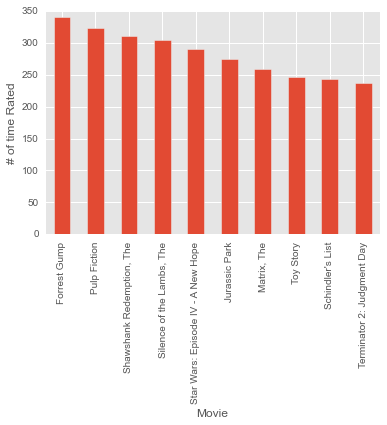

In [10]:
#top 10 movies in terms of number of ratings. 
topMovie=movieRating.title.value_counts()[:10]
tm=topMovie.plot(kind='bar')
plt.ylabel('# of time Rated')
plt.xlabel("Movie")
plt.show()

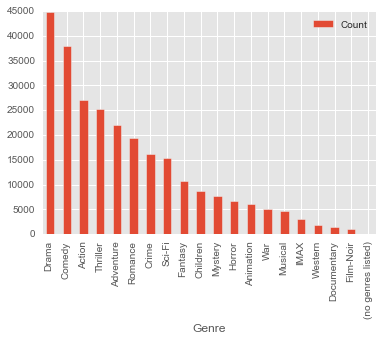

In [11]:
moviesRated=ratings.merge(movies,on="movieId")
Genres=[]
for gen in moviesRated.genres:
    try:
        Genres.extend(gen.encode().split("|"))
    except:
        pass
dfGenres=pd.DataFrame([(x,Genres.count(x)) for x in set(Genres)] ,columns=["Genre","Count"]).sort_values(by='Count',ascending=False)
dfGenres.plot(kind="bar",x="Genre",y="Count")

The above chart shows number of time each genre movie was rated.

Let's now look at the user features:

In [16]:
df_user.head()

,userId,age,gender,occupation,zip_code
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213


Average age of users:  33.9925484352
Minimum age of user in data:  7
Maximum age of user in data:  73


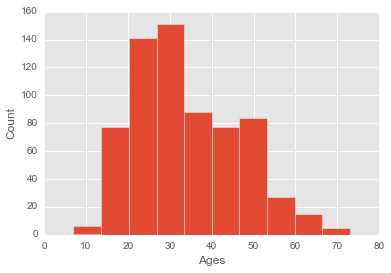

In [18]:
#user age breakdown
print "Average age of users: ",df_user.age.mean()
print "Minimum age of user in data: ",df_user.age.min()
print "Maximum age of user in data: ",df_user.age.max()
plt.hist(df_user.age, bins=10);
plt.xlabel("Ages")
plt.ylabel("Count")
plt.show()

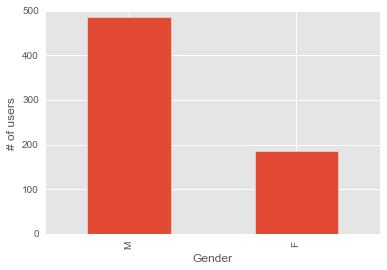

In [19]:
#gender breakdown
genderC=df_user.gender.value_counts()
gc=genderC.plot(kind='bar')
plt.ylabel('# of users')
plt.xlabel("Gender")
plt.show()

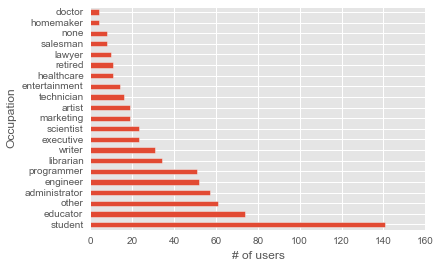

In [20]:
#occupation breakdown
occC=df_user.occupation.value_counts()
oc=occC.plot(kind='barh')
plt.xlabel('# of users')
plt.ylabel("Occupation")
plt.show()

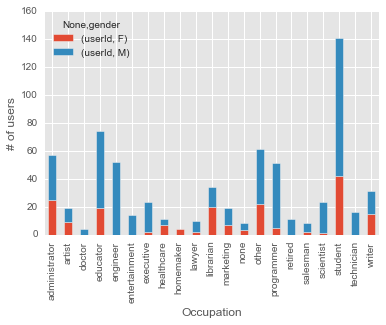

In [22]:
genderOccCategory=df_user[["occupation","gender","userId"]].groupby(by=["occupation","gender"]).count()
genderOccCategory.unstack().plot(kind="bar",stacked=True)
plt.ylabel('# of users')
plt.xlabel("Occupation")
plt.show()

The graph above shows the ratio of Men to Women for each occupation in the user dataset.

### Building the Recommendation Model 

##### Collaborative Filtering Overview

In collaberative-filtering, the matrix factorization method discovers latent features underlying the interactions between user and movie, assuming the inner product of user's latent features $u_i$ and movies latent $v_j$ is the rating:
$$h_\mathbf{\theta}(i,j) = \mathbf{u_i^T v_j}$$
Suppose there are $k$ latent features in $u$ and $v$. Then the model can be thought of describing how each latent feature $k$ matches to each other. For example, if the number of latent variables $k$ is 4:
$$\mathbf{u_i} = [0.4, 0.5, -0.3, 0.7]$$ $$\mathbf{v_j} = [0.2, -0.6, -0.2. 0.3]$$
The rating will be the inner product of these two vectors:
$$[0.4*0.2]_{feature1}+[0.5*(-0.6)]_{feature2}+[(-0.3)*(-0.2)]_{feature_3}+[0.7*0.3]_{feature4} = 0.05 $$

Then by minimizing the loss funtion, it is effectively finding the latent features and the coeficients that minimize the error of the reconstructed matrix compared to the training data.
$$\sum_{i,j\in S}\ell(h_\theta(i,j),\mathbf{X}_{ij}) + \lambda_u ||\mathbf{U}||_2^2 + \lambda_v ||\mathbf{V}||_2^2$$

#### Different Alternatives

The motivation for this project is that there are some pitfalls with collaborative filtering: 
* It is hard to interpret the meaning of latent features.
* The inner product suggest that the rating is the linear combination of the latent features, which might not be true.
* There is a lot of information available that influences the rating which is not utilized. 

Two other methods will be explored in this project: Linear Regression (having a model for each user) and Factorization Machines.

##### Linear Regression

The intuition for a Linear Regression algorithm here is to treat each person is a regressor, where the input features are the defined movie attributes. In other words, it is equal to minimize the loss function for each person given rating history independently:
$$\sum_{j\in S}\ell(h_{\theta_i}(\mathbf{x}_j), \mathbf{X}_{ij}) $$, where i denotes a person and his/her preferences are encoded in parameter $\mathbf{\theta}_i$, $\mathbf{x}_j$ is the feature vector of the movie (with features such as genre, actors, year,etc...), and $h$ is the hypothesis function. For example, given a movie with features $m_j$={'1996', 'action, romance', ...}, a person with preferences $\theta_i$={'>1950', 'action || romance', ...} will output a rating value through a model $h$ (i.e. decision tree, SVM, cosine simlarity, ...).

Assume the rating is the output of the linear regression model:
$$h_{\theta_i}(\mathbf{x_j}) = \mathbf{\theta_i}^T\mathbf{x_j} $$, where $\theta_i$ is the user parameter and $x_j$ (k x 1) is the movie feature (k x 1).

The goal is to minimize the mean square error. For each user, the parameter could be solved by constructing a matrix $\mathbf{X}$ based on the past rating history, and it is a standard form of least square.
For example, if user i rated m movies, the equation will be: 

$$\mathbf{\theta_i^*} = \arg \min_{\theta} ||\mathbf{X\theta - y}||_2$$, where $\mathbf{X}$ is a m x k matrix and each row is a movie feature vector $\mathbf{x}$, $\mathbf{\theta_i}$ is a k x 1 column vector of user i's parameter.

In this experiement, three numeric feature {'year', 'runtime', 'vote'} are selected as the movie feature (i.e k = 3), and the number of user and movies are as same as the collaberative filter setting.

##### Factorization Machines

One of the limitations of Collaborative Filtering is that is restricted to only using ratings without integrating information particular to the users and movies. Factorization Machines help to solve exactly this by using both movie and user features to build vectors and find the importance of individual features as well as the interactions between them. A factorization machine of degree d=2 is given by

$$ y(x) = w_0 + \sum_{i=1}^{n}w_ix_i + \sum_{i=1}^{n}\sum_{j=i+1}^{n}(v_i,v_j)x_ix_j $$ 

,where $w_0$ is the global bias, $w_i$ models the strength of the i-th variable, and $(v_i,v_j)$ models the interaction between the i-th and j-th variable.

For this project we are using the implementation of the pyFM library, which uses  stochastic gradient descent and adaptive regularization to solve the algorithm.
https://devhub.io/repos/pprett-pyFM

### CF Experiments

In [23]:
np.random.seed(10)
# Collaberative Filtering
X_tr, X_te, movieNames, _, idxToLenId = cf.process(ratings, movies, np.random.permutation(len(ratings)))
param_k = [1,3,5,10,20,50]
UV_cfs = [cf.train(X_tr, X_te, k = i, lam = 1, niters = 16, verbose = False) for i in param_k]

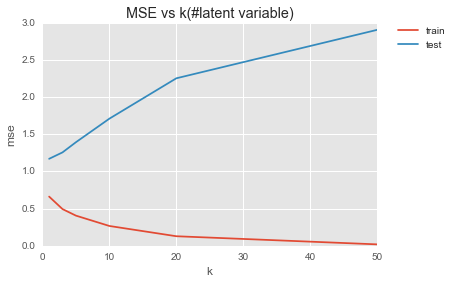

In [24]:
#error vs latent variables
plt.plot(param_k, [cf.error(X_tr, uv[0], uv[1]) for uv in UV_cfs], label = 'train')
plt.plot(param_k, [cf.error(X_te, uv[0], uv[1]) for uv in UV_cfs], label = 'test')
plt.title('MSE vs k(#latent variable)')
plt.xlabel('k')
plt.ylabel('mse')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

As it can be observed below, the MSE of the test set increases as k increases, leaving k=1 as the optimal k.

In [25]:
param_it = [1,3,5,10,20,50]
UV_cfs = [cf.train(X_tr, X_te, k = 1, lam = 1, niters = i, verbose = False) for i in param_it]

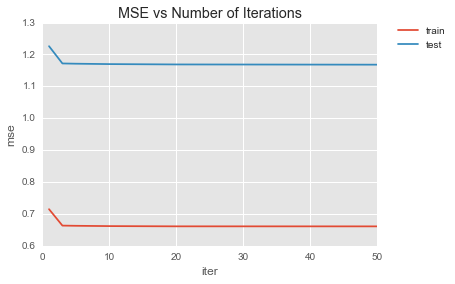

In [26]:
#number of iterations vs MSE
plt.plot(param_it, [cf.error(X_tr, uv[0], uv[1]) for uv in UV_cfs], label = 'train')
plt.plot(param_it, [cf.error(X_te, uv[0], uv[1]) for uv in UV_cfs], label = 'test')
plt.title('MSE vs Number of Iterations')
plt.xlabel('iter')
plt.ylabel('mse')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

After a small number of iterations one can see that both errors are essentially converging.

In [27]:
#lowest test error after 1 iteration
np.random.seed(10)
X_tr, X_te, movieNames, idxToUserId, idxToLenId = cf.process(ratings, movies, np.random.permutation(len(ratings)))
U_cf, V_cf = cf.train(X_tr, X_te, k = 1, lam = 1, niters = 51, verbose = True)

Iter: 000	train error: 0.703	Test error: 1.2171
Iter: 005	train error: 0.662	Test error: 1.1708
Iter: 010	train error: 0.662	Test error: 1.1698
Iter: 015	train error: 0.661	Test error: 1.1692
Iter: 020	train error: 0.661	Test error: 1.1688
Iter: 025	train error: 0.661	Test error: 1.1685
Iter: 030	train error: 0.661	Test error: 1.1684
Iter: 035	train error: 0.661	Test error: 1.1682
Iter: 040	train error: 0.661	Test error: 1.1681
Iter: 045	train error: 0.661	Test error: 1.1681
Iter: 050	train error: 0.661	Test error: 1.1681


### Linear Regression Experiments

In [28]:
# Linear Regression using features of year and votes
#reload(lr)
V_lr = lr.process(df_movies, idxToLenId, links, features = ['year', 'votes'])
U_lr = lr.train(X_tr, V_lr, lam = 1)

In [29]:
# LR vs CF Evaluation using MSE
train_mse, test_mse = cf.error(X_tr, U_cf, V_cf), cf.error(X_te, U_cf, V_cf)
print "CF Train error: {:0.4f} Test error: {:0.4f}".format(train_mse, test_mse)

train_mse, test_mse = cf.error(X_tr, U_lr, V_lr), cf.error(X_te, U_lr, V_lr)
print "LR Train error: {:0.4f} Test error: {:0.4f}".format(train_mse, test_mse)

CF Train error: 0.6609 Test error: 1.1681
LR Train error: 0.8585 Test error: 0.8859


From the results above one can observe that a LR model, using only the numeric features of votes and year, beats the performance of the CF model. This is something to be suspicious of since CF is a well established algorithm. With the following graphs we are attempting to find out why LR performed better.

##### Features relevance

In [30]:
# Year only
V_lr = lr.process(df_movies, idxToLenId, links, features = ['year'])
U_lr = lr.train(X_tr, V_lr, lam = 1)
train_mse, test_mse = cf.error(X_tr, U_lr, V_lr), cf.error(X_te, U_lr, V_lr)

print "Year only:"
print "LR Train error: {:0.4f} Test error: {:0.4f}".format(train_mse, test_mse)
print 

# Votes only
V_lr = lr.process(df_movies, idxToLenId, links, features = ['votes'])
U_lr = lr.train(X_tr, V_lr, lam = 1)
train_mse, test_mse = cf.error(X_tr, U_lr, V_lr), cf.error(X_te, U_lr, V_lr)

print 'Votes only:'
print "LR Train error: {:0.4f} Test error: {:0.4f}".format(train_mse, test_mse)

Year only:
LR Train error: 0.9152 Test error: 0.9320

Votes only:
LR Train error: 0.8586 Test error: 0.8895


The number of votes seems to be most important feature although the MSE is slightly lower when both features are included in the model.

##### Year vs Rating comparison

In [26]:
#parse and process df_movies and df_users
df_movies = movie_parsing.parse(df_movies)
df_movies,df_users = process_data.process(df_movies,df_user)

In [33]:
df_merged = ratings.merge(df_user, on='userId').merge(links.drop('tmdbId',axis=1),on='movieId').merge(df_movies,on='imdbId')
df_merged.dropna(subset=["year"], inplace=True)

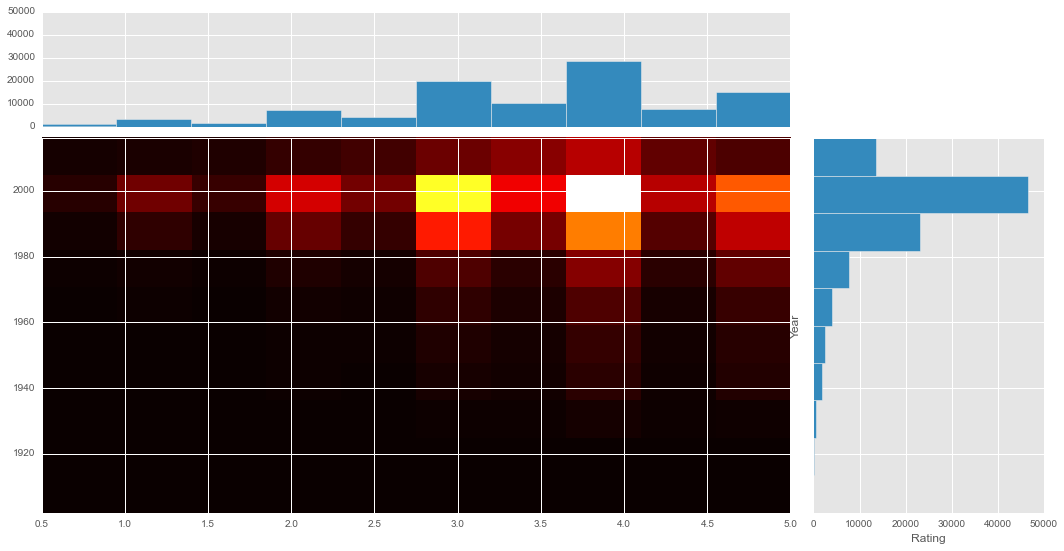

In [33]:
from matplotlib.ticker import NullFormatter
from matplotlib.colors import LogNorm

# Define the locations for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
bottom_h = left_h = left + width + 0.02

# Set up the geometry of the three plots
rect_hist2d = [left, bottom, width, height]
rect_histx = [left, bottom_h, width, 0.2]
rect_histy = [left_h, bottom, 0.2, height]

# Set up the size of the figure
plt.figure(1, figsize=(16, 8))

# Make the three plots
axHist2D = plt.axes(rect_hist2d)
axHistx = plt.axes(rect_histx) # x histogram
axHisty = plt.axes(rect_histy) # y histogram

# Remove the inner axes numbers of the histograms
nullfmt = NullFormatter()
axHistx.xaxis.set_major_formatter(nullfmt)
axHisty.yaxis.set_major_formatter(nullfmt)

y = df_merged['rating'].values
x = df_merged['year'].values

axHist2D.hist2d(y, x, cmap="hot")
axHistx.hist(x)
axHisty.hist(y, orientation='horizontal')

xbinwidth = 0.5
ybinwidth = 5
xmax, ymax = np.max(x), np.max(y)

xlim = (int(xmax/xbinwidth) + 1) * xbinwidth
ylim = (int(ymax/ybinwidth) + 1) * ybinwidth

xbins = np.arange(0, xlim + xbinwidth, xbinwidth) 
ybins = np.arange(0, ylim + ybinwidth, ybinwidth)

# bins = np.arange(-lim, lim + binwidth, binwidth)
axHistx.hist(y)#, bins = ybins)
axHisty.hist(x,orientation='horizontal')#, bins = xbins)

axHistx.set_xlim(axHist2D.get_xlim())
axHisty.set_ylim(axHist2D.get_ylim())
plt.xlabel('Rating')
plt.ylabel('Year')

From the figure above one can infer that most ratings are of movies in the range 2000-2010 and in general these movies have the largest rating. It also seems that the popularity of rating movies is fading compared to the 2000s.

In [36]:
np.random.seed(10)
n = len(df_merged)
P = np.random.permutation(n)
df_tr = df_merged.iloc[P[:int(math.floor(9*n /10.))]]
df_te = df_merged.iloc[P[int(math.floor(9*n /10.)):]]

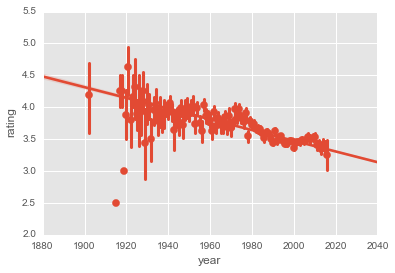

In [35]:
#plot of rating vs year for training data
seaborn.regplot(x = df_tr['year'], y = df_tr['rating'], scatter = True, fit_reg = True, x_estimator=np.mean)

In [38]:
#plot of rating vs votes for training data
seaborn.regplot(x = df_tr['votes'], y = df_tr['rating'], scatter = True, fit_reg = True, x_estimator=np.mean)

The plots above help to illustrate why votes and year appear to be good predictors for the rating, especially as shown in the rating vs year plot. A simple line seems to fit well the data, leading to a low MSE in the LR model. Despite the low MSE, one should not trust the results of using two features in a simple LR model since one can expect it won't generalize well for new movies. 

### Factorization Machines

In [44]:
#split data
np.random.seed(10)
P = np.random.permutation(len(df_merged))
n = len(ratings)
ratings_tr = df_merged.iloc[P[:int(math.floor(9*n /10.))]]
ratings_te = df_merged.iloc[P[int(math.floor(9*n /10.)):]]

In [46]:
#format data in the proper format for pyFM
#reload(tokenizer)
features = ['imdbId', 'userId']
train_data, y_tr = tokenizer.tokenize(ratings_tr, features)
test_data, y_te = tokenizer.tokenize(ratings_te, features)

v = DictVectorizer()
X_train = v.fit_transform(train_data)
X_test = v.transform(test_data)

In [54]:
#fit models and collect errors
models, train_error, test_error = experiemnt_fm.latent_error(X_train, y_tr, X_test, y_te, lr = 1E-2)

In [ ]:
#generate training and test error plots
plt.plot([k for k, err in train_error], [err for k, err in train_error], 'b', label = 'train_error')
plt.plot([k for k, err in test_error], [err for k, err in test_error], 'g', label = 'test_error')
plt.legend()
plt.xlabel('iteration')
plt.ylabel('MSE')
plt.title('#Iterations vs MSE \nusing userId and movieId')

Using the essence of the code above and the pyFM implementation of FM, the following experiments were conducted. 

** They were ran in another machine and the pictures were imported.

<img src="./fig/train error vs test error FM.jpeg" style="width:700px;height:300px;">

Minimum MSE (going by test error), at 50 iterations:

Train Error: 0.531;
Test Error: 0.768

<img src="./fig/train error vs test error FM2.png" style="width:700px;height:300px;">

Minimum MSE:

Train Error: 0.865; Test Error: 0.990

In [55]:
#using mean to predict (for reference)
MSE_mean = np.mean((df_te['rating']-df_tr['rating'].mean())**2)
print "MSE using the mean rating to predict: ", MSE_mean

MSE using the mean rating to predict:  1.1172839805


### Conclusion

Our best implementation of Collaborative Filtering yielded an MSE of 1.1681 on the test set. This is despite CF being a well established algorithm for this specific task. Given that ratings go from 0.5 to 5.0, an error of 1.1681 is a mediocre performance. Furthermore, this is worse than using the mean of the training data as a predictor. It is likely that the poor performance is because too many values were missing.

The simple Linear Regression model worked quite surprisingly, having an MSE of 0.8859 using only release year and number of votes as predictors along with a bias term. As illustrated in the graphs above, fitting a simple line over the data seems to be a good model. One can expect that such a model would not perform as well on movies recently released and/or rarely reviewed. Furthermore, it does not seem logic that such a simple model with two features would perform better than CF.

The Factorization Machine model is probably the one with the most potential and the one we least explored. Merely using one hot encondings of the users and the movies the model obtained an MSE of 0.768 on the test data, outperforming the best results obtained for the other algorithms. 

Another model built included the features one hot encodings of movies and users as well as the release year of the movie. The performance was worst by including this feature. Properly normalizing the data would have helped to prevent this. 

#### Future Work/Comments

In future work we would have spent more time on analyzing and improving the Factorization Machine model. Information contained in movie features such as plot and cast could have been included to the model using a TFIDF approach. Also, after having the built the different models, we could have analyzed the weights of the different parameters trying to find particular features that further help to understand the dataset. Including numerical features led to the gradient descent to diverge, although doing proper normalization of the data would have helped.

A significant amount of time was spent in the processing of the data. After downloading the data using the API, storing the data in a csv without the right enconding and format forced us to have to parsed things over and over again. Also, the different models and their libraries, if applicable, required to have the data in different formats, adding more to the inconsistency of the representation of the data and communication issues. 